# Week 03 — Classical ML Foundations

This notebook covers linear and logistic regression, connecting statistical foundations to ML practice. You'll:
- Implement closed-form solutions (normal equations) and iterative methods
- Understand bias-variance tradeoff empirically
- Build and evaluate classical models

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

np.random.seed(42)
print("Libraries imported!")

Libraries imported!


In [2]:

import os, pickle

CACHE_DIR = "cache_week03"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print("Cache utilities ready. Results will be stored in:", CACHE_DIR)


Cache utilities ready. Results will be stored in: cache_week03


## 1. Linear Regression: Closed-Form Solution

Derive and implement the normal equations for linear regression.

Fitted parameters: w0=2.004, w1=2.964
True parameters: w0=2.000, w1=3.000


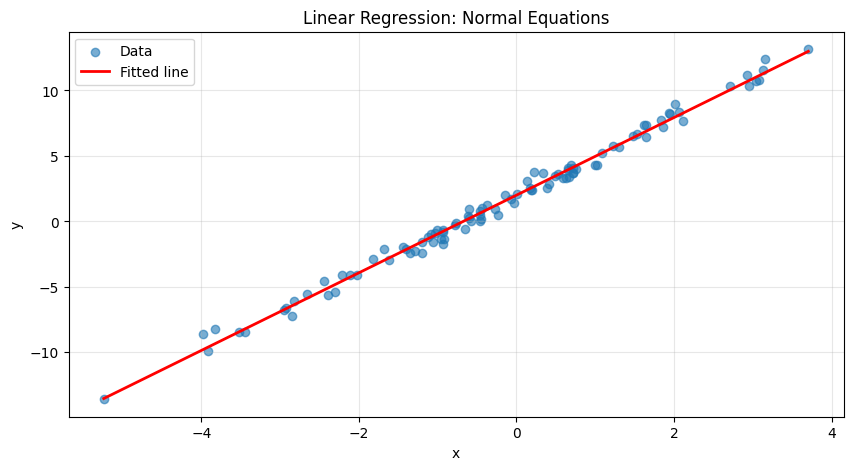

In [3]:
# Generate synthetic linear data
n_samples = 100
X = np.random.randn(n_samples, 1) * 2
y_true = 3 * X.squeeze() + 2
y = y_true + np.random.randn(n_samples) * 0.5

# Add bias term (column of ones)
X_with_bias = np.hstack([np.ones((n_samples, 1)), X])

# Closed-form solution: w = (X^T X)^{-1} X^T y
def normal_equations(X, y):
    """Solve linear regression using normal equations"""
    XTX = X.T @ X
    XTy = X.T @ y
    w = np.linalg.solve(XTX, XTy)
    return w

# Fit model
w = normal_equations(X_with_bias, y)
print(f"Fitted parameters: w0={w[0]:.3f}, w1={w[1]:.3f}")
print(f"True parameters: w0=2.000, w1=3.000")

# Plot results
plt.figure(figsize=(10, 5))
plt.scatter(X, y, alpha=0.6, label='Data')
X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_line_bias = np.hstack([np.ones((100, 1)), X_line])
y_pred = X_line_bias @ w
plt.plot(X_line, y_pred, 'r-', linewidth=2, label='Fitted line')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression: Normal Equations')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 2. Compare to scikit-learn

Verify our implementation matches sklearn.

In [4]:
# Fit with sklearn
sklearn_model = LinearRegression()
sklearn_model.fit(X, y)

print("Our implementation:")
print(f"  Intercept: {w[0]:.6f}, Slope: {w[1]:.6f}")
print("\nsklearn:")
print(f"  Intercept: {sklearn_model.intercept_:.6f}, Slope: {sklearn_model.coef_[0]:.6f}")
print("\nMatch:", np.allclose([w[0], w[1]], [sklearn_model.intercept_, sklearn_model.coef_[0]]))

Our implementation:
  Intercept: 2.003714, Slope: 2.964186

sklearn:
  Intercept: 2.003714, Slope: 2.964186

Match: True


## 3. Logistic Regression

Implement and visualize logistic regression for binary classification.

[cache] computing 'logistic_regression_clf_sep1.5'...
Train accuracy: 0.929
Test accuracy:  0.933


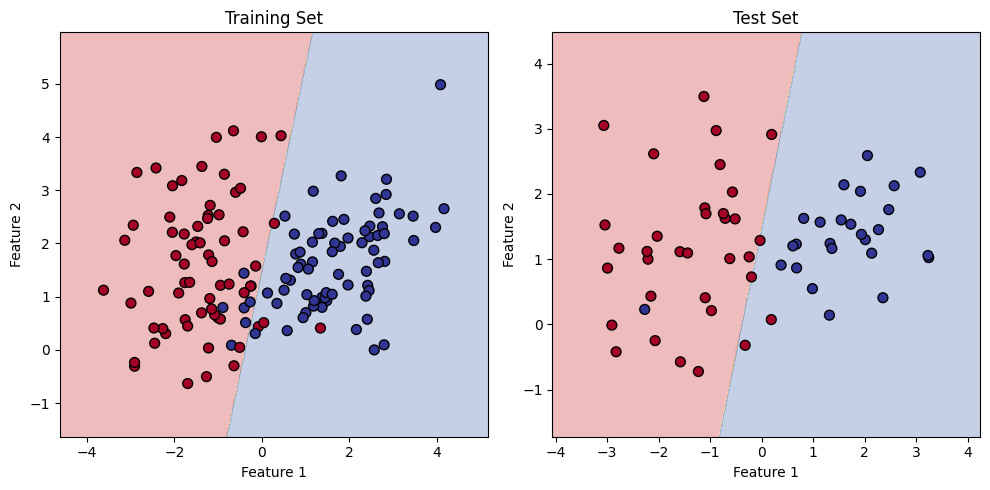

In [5]:

from sklearn.datasets import make_classification

X_clf, y_clf = make_classification(n_samples=200, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1,
                                   class_sep=1.5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)

def _fit_logistic():
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

log_reg = cached("logistic_regression_clf_sep1.5", _fit_logistic)

train_acc = log_reg.score(X_train, y_train)
test_acc  = log_reg.score(X_test,  y_test)
print(f"Train accuracy: {train_acc:.3f}")
print(f"Test accuracy:  {test_acc:.3f}")

def plot_decision_boundary(model, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='k', s=50)
    plt.xlabel('Feature 1'); plt.ylabel('Feature 2')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plot_decision_boundary(log_reg, X_train, y_train); plt.title('Training Set')
plt.subplot(1, 2, 2); plot_decision_boundary(log_reg, X_test,  y_test);  plt.title('Test Set')
plt.tight_layout(); plt.show()


## 4. Bias-Variance Tradeoff

Explore the bias-variance tradeoff by varying model complexity using polynomial features.

[cache] computing 'bias_variance_poly_degrees'...


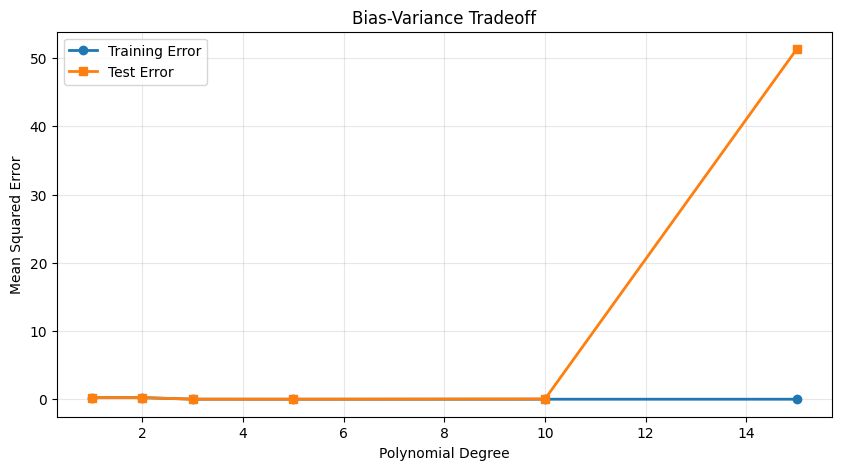


Optimal degree minimizing test error: 5


In [6]:

np.random.seed(42)
X_poly = np.linspace(0, 1, 30).reshape(-1, 1)
y_poly = np.sin(2 * np.pi * X_poly).ravel() + np.random.randn(30) * 0.1
X_tr, X_te, y_tr, y_te = train_test_split(X_poly, y_poly, test_size=0.3, random_state=42)

degrees = [1, 2, 3, 5, 10, 15]

def _compute_bias_variance():
    train_errors, test_errors = [], []
    for degree in degrees:
        poly = PolynomialFeatures(degree=degree)
        X_tr_poly = poly.fit_transform(X_tr)
        X_te_poly = poly.transform(X_te)
        model = LinearRegression()
        model.fit(X_tr_poly, y_tr)
        train_errors.append(mean_squared_error(y_tr, model.predict(X_tr_poly)))
        test_errors.append(mean_squared_error(y_te, model.predict(X_te_poly)))
    return train_errors, test_errors

train_errors, test_errors = cached("bias_variance_poly_degrees", _compute_bias_variance)

plt.figure(figsize=(10, 5))
plt.plot(degrees, train_errors, 'o-', label='Training Error', linewidth=2)
plt.plot(degrees, test_errors,  's-', label='Test Error',     linewidth=2)
plt.xlabel('Polynomial Degree'); plt.ylabel('Mean Squared Error')
plt.title('Bias-Variance Tradeoff'); plt.legend(); plt.grid(alpha=0.3)
plt.show()
print("\nOptimal degree minimizing test error:", degrees[np.argmin(test_errors)])


## Exercises for Further Practice

1. **Regularized Regression**: Implement Ridge regression from scratch using the modified normal equations
2. **Gradient-Based Fit**: Implement linear regression using gradient descent and compare to closed-form
3. **Multi-class Classification**: Use LogisticRegression with multi-class data (iris dataset)
4. **Cross-Validation**: Implement k-fold CV to select polynomial degree
5. **Real Dataset**: Apply linear/logistic models to a UCI dataset of your choice

## Deliverables Checklist

- [ ] Normal equations implementation and comparison to sklearn
- [ ] Logistic regression with decision boundary visualization
- [ ] Bias-variance experiment with plots
- [ ] Mini-project applying models to real dataset

## Recommended Resources

- Bishop, "Pattern Recognition and Machine Learning" (Chapter 3)
- scikit-learn documentation on linear models
- Stanford CS229 lecture notes on supervised learning

In [7]:

# EXERCISE 1 — Ridge Regression from Scratch
# Goal: derive the Ridge closed-form solution: w = (X^T X + λI)^{-1} X^T y.
# Implement it, then compare its coefficients to sklearn Ridge(alpha=1.0).
# Sweep λ in [0.001, 0.01, 0.1, 1, 10] and plot coefficient norm vs λ.
# Expected insight: larger λ shrinks all weights toward zero (L2 regularization).


In [8]:

# EXERCISE 2 — Gradient-Descent Linear Regression
# Goal: implement linear regression via GD (not the normal equations).
# Use MSE loss and its gradient. Run for 500 steps with lr=0.01.
# Plot loss curve and overlay the GD fit line vs the closed-form one.
# Expected insight: GD converges to the same solution as normal equations.


In [9]:

# EXERCISE 3 — Multi-Class Logistic Regression (Iris dataset)
# Goal: load sklearn's Iris dataset (3 classes). Fit LogisticRegression(max_iter=200).
# Report per-class precision/recall and draw a confusion matrix.
# Use cached("logistic_regression_iris", ...) to save the fitted model.
# Expected insight: the "setosa" class is perfectly separable; the other two overlap.


In [10]:

# EXERCISE 5 — Real Dataset Mini-Project
# Goal: pick any tabular dataset (e.g. sklearn's California Housing or Diabetes).
# Split 80/20. Fit LinearRegression, Ridge, and LogisticRegression (if classification).
# Report R² (regression) or accuracy (classification) for train and test.
# Deliverable: one paragraph interpreting the results and any over/underfitting signs.
